<a href="https://colab.research.google.com/github/charlesreid1/deep-learning-genomics/blob/master/keras_sklearn_cnn1d_dna_transcription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras and Sklearn for Deep Learning Genomics

## Using Convolutional Neural Nets to Predict CRP Transcription Factor Binding Sites

This notebook continues with the example from a prior notebook, namely, the problem of predicting transcription factor binding sites in DNA. This type of neural network operates on 1D sequence data (DNA nucleotides), so we build a 1D convolutional neural network to perform classification of DNA (is this string of nucleotides a transcription factor binding site or not).

We construct a 1D CNN model in this notebook, then perform manual cross-validation on each model and assemble statistics to assess the cross-validation results.

## Import Libraries

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [2]:
import os
import math
import numpy as np
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import joblib

In [122]:
from scipy import interp

In [7]:
!pip install screed

In [126]:
# sklearn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [4]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, Model
from keras.layers import Flatten, Embedding, Dense, Dropout, Input, Concatenate
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.layers import LeakyReLU
import keras

Using TensorFlow backend.


In [5]:
seed = 1729
numpy.random.seed(seed)

## Define Useful Keras Metrics

In [6]:
# via https://github.com/keras-team/keras/issues/6507#issuecomment-322857357

import keras.backend as K

def precision(y_true, y_pred):
    # Calculate the precision
    # clip ensures we're between 0 and 1
    # round ensures we're either 0 or 1
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    # Calculate the recall
    # clip ensures we're between 0 and 1
    # round ensures we're either 0 or 1
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fvalue(y_true, y_pred):
    # Calculate the F-value
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0
    p = precision(y_true,y_pred)
    r = recall(y_true,y_pred)
    fvalue = (2 * p * r)/(p + r + K.epsilon())
    return fvalue


## Load Dataset

In [8]:
# grab binding sites from http://arep.med.harvard.edu/ecoli_matrices/dat/crp.dat
!wget http://arep.med.harvard.edu/ecoli_matrices/dat/crp.dat

--2019-06-24 15:21:05--  http://arep.med.harvard.edu/ecoli_matrices/dat/crp.dat
Resolving arep.med.harvard.edu (arep.med.harvard.edu)... 134.174.150.51
Connecting to arep.med.harvard.edu (arep.med.harvard.edu)|134.174.150.51|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1966 (1.9K) [text/plain]
Saving to: ‘crp.dat’

crp.dat             100%[===================>]   1.92K  --.-KB/s    in 0.02s   

2019-06-24 15:21:06 (86.1 KB/s) - ‘crp.dat’ saved [1966/1966]



In [9]:
# grab ecoli k12 genome
!curl ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/003/627/195/GCF_003627195.1_ASM362719v1/GCF_003627195.1_ASM362719v1_genomic.fna.gz -o ecoli-k12.fna.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1347k  100 1347k    0     0   304k      0  0:00:04  0:00:04 --:--:--  309k


In [46]:
import screed
ecoli_genome = list(screed.open('ecoli-k12.fna.gz'))[0].sequence
crp_sites = list(screed.open('crp.dat'))

In [47]:
ecoli_genome = ecoli_genome.upper()

## Explore Dataset

Below we explore some details of the CRP transcription factor binding site data set that we'll use to train and test the model.

In [48]:
print("E. coli genome size: {:,}".format(len(ecoli_genome)))
print("Number of CRP binding sites: {:,}".format(len(crp_sites)))

E. coli genome size: 4,639,694
Number of CRP binding sites: 49


In [49]:
print(type(ecoli_genome))

<class 'str'>


The E. coli genome is a ~4 MB string and we have 49 known binding sites. We have only "known positive" binding sites; we have no "known negative" binding sites. In other words, we cannot say that a particular sequence of DNA is _definitely not_ a binding site, we can only say that it is _probably not_ a binding site.

In [50]:
crp_sites[:5]

[{'name': 'aldB -18->4', 'sequence': 'attcgtgatagctgtcgtaaag', 'description': ''},
 {'name': 'ansB 103->125', 'sequence': 'ttttgttacctgcctctaactt', 'description': ''},
 {'name': 'araB1 109->131', 'sequence': 'aagtgtgacgccgtgcaaataa', 'description': ''},
 {'name': 'araB2 147->169', 'sequence': 'tgccgtgattatagacactttt', 'description': ''},
 {'name': 'cdd 1 107->129', 'sequence': 'atttgcgatgcgtcgcgcattt', 'description': ''}]

### Generating Positive Examples

In [60]:
crp_kmers = []
for site in crp_sites:
    crp_kmers.append(site['sequence'].upper())

len_crp = len(crp_kmers[0]) # all CRP sites are the same length
print('Size of CRP binding site:', len_crp)
print('Number of known good CRP binding sites:', len(crp_kmers))

Size of CRP binding site: 22
Number of known good CRP binding sites: 49


The CRP binding sites are all sequences of 22 nucleotides. We have 49 positive examples. 

### Kmer Orientations and Reverse Complements

Normally we would want to think about whether the orientation of the kmer (forward or backward from what is given in the data set we downloaded) matters. However, the CRP t.f. binding sites are all palindromes, so orientation should not matter.

However, we _can_ generate additional positive examples by finding the reverse complement of each CRP t.f. binding site kmer.

In [61]:
TRANSLATION = {"A": "T", "C": "G", "G": "C", "T": "A"}

def revc(pattern):
    return "".join(TRANSLATION[c] for c in reversed(pattern))

for k in range(len(crp_kmers)):
    crp_kmers.append(revc(crp_kmers[k]))

print('Number of known good CRP binding sites (with rev. complements):', len(crp_kmers))

Number of known good CRP binding sites (with rev. complements): 98


### Generating Negative Examples

Next, we can generate negative examples (ignoring the fact mentioned above, that we can't say with certainty that these are negative examples) by generating 22-mers from the E. coli genome.

We will generate a **slim** and a **full** data set. The slim data set will use the first 100,000 22-mers. The full data set will use the entire E. coli genome.

In [62]:
do_slim = True

In [63]:
if do_slim:
    
    N_NEGATIVES=int(1e5) # 100,000 negative binding sites

    notcrp_kmers_slim = []
    for n in range(N_NEGATIVES):
        kmer = ecoli_genome[n:n + len_crp]
        if kmer not in crp_kmers:
            notcrp_kmers_slim.append(kmer)

    print('Gathered {:,} negative binding sites'.format(len(notcrp_kmers_slim)))

Gathered 99,999 negative binding sites


In [64]:
if not do_slim:
    
    notcrp_kmers_full = []
    overlap = len(ecoli_genome)-len_crp+1
    for n in range(overlap):
        kmer = ecoli_genome[n:n + len_crp]
        if kmer not in crp_kmers:
            notcrp_kmers_full.append(kmer)

    print('Gathered {:,} negative binding sites'.format(len(notcrp_kmers_full)))

In [65]:
if do_slim:
    notcrp_kmers = notcrp_kmers_slim
else:
    notcrp_kmers = notcrp_kmers_full

A brief comment on dealing with uncertainty in the positive and negative cases: this is a source of uncertainty inherent to the system being modeled - it is not something that can be overcome with a better model. Training a better model requires more information, in the form of probabilities - the probability that a kmer is a negative example. In the absence of additional information, such as an estimate of the number of missing positive examples, we have to make assumptions.

Ultimately the output of the model is a probabilistic guess about which class a given kmer belongs in - positive (yes, this is a CRP t.f. site) or negative (no, this is not a CRP t.f. site). We are looking for places where we can't quite rule something out based on the data we have, and the classification system is **more sensitive** to the training data set.

### One-Hot Encoding of Dataset

To use the kmers that compose our positive and negative exmaples, we need to one-hot encode the DNA sequences.

In [67]:
# do janky one-hot encoding
oh = {}
oh['A'] = [1, 0, 0, 0]
oh['C'] = [0, 1, 0, 0]
oh['G'] = [0, 0, 1, 0]
oh['T'] = [0, 0, 0, 1]

X = []
y = []

# First encode the positive examples

for site in crp_kmers:
    encoded_site = []
    for c in site:
        encoded_site.append(oh[c])
    
    X.append(encoded_site)
    y.append([1])
        

for site in notcrp_kmers:
    encoded_site = []
    for c in site:
        encoded_site.append(oh[c])
    
    X.append(encoded_site)
    y.append([0])

In [72]:
# Setting the dtype can save us some space
X = np.array(X, dtype=np.int8)
y = np.array(y, dtype=np.int8)

print(np.shape(X))
print(np.shape(y))

(100097, 22, 4)
(100097, 1)


In [73]:
print(type(X[0][0][0]))
print(type(y[0][0]))

<class 'numpy.int8'>
<class 'numpy.int8'>


In [88]:
pos = sum(y==1)
neg = sum(y==0)
print("Percent of examples that are positive: %0.2f%%"%(100*pos/(pos+neg)))

Percent of examples that are positive: 0.10%


### Computing Class and Sample Weights

Because we are dealing with a highly imbalanced data set, we should use class weights to weight the positive examples more heavily, so the neural network doesn't learn to simply make negative preditions all the time.

Class weights are easier to deal with and apply the same weight to all instances of a given class.

Sample weights assign a different weight to every piece of input data. These are more expensive and consume space, but some scikit-learn functions can only accept sample weights, not class weights.

In [166]:
# Compute class weights:
classes = np.unique(y)
labels = np.squeeze(y)
weights = compute_class_weight('balanced',classes,labels)

class_weights = {}
for k,wt in zip(classes,weights):
    class_weights[k] = wt

sample_weights = []
for yi in y:
    k = yi[0]
    sample_weights.append([class_weights[k]])

sample_weights = np.array(sample_weights)

## Performing Stratified K-Fold Validation

Now we have all input and output data for training the neural network model in the variables X and y. We can use scikit-learn to create testing-training splits that maintain a balance between positive and negative examples. 

* First, we write a function to create a model (independent of input/output data).
* Second, we perform k-fold validation, creating a new model each time. We create new stratified, shuffled testing-training splits from X and y each time we do a new cross-validation.

In [152]:
def create_baseline():
    """Create and return a baseline 1D convolutional neural net model.
    """
    # DNA sequence alphabet size
    n_features = 4
    seq_length = len_crp
    convolution_window = 25
    n_filters = 16
    
    # construct model
    model = Sequential()
    
    # Layer 1
    model.add(Conv1D(n_filters, convolution_window,
                     activation='relu',
                     padding='same',
                     kernel_initializer='normal',
                     input_shape=(seq_length, n_features)))
    
    model.add(Dropout(0.5))
    
    # Layer 2
    model.add(Conv1D(n_filters, convolution_window,
                     activation='relu', 
                     padding='same',
                     kernel_initializer='normal'))
    
    model.add(Dropout(0.5))
    
    # Layer 3
    model.add(Conv1D(n_filters, convolution_window,
                     activation='relu', 
                     padding='same',
                     kernel_initializer='normal'))
    
    model.add(Dropout(0.5))
    
    # Flatten
    model.add(Flatten())
    
    # Shrink to 1 neuron for 1 class (binary) classification
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  sample_weight_mode=None,
                  metrics=['accuracy',
                           precision,
                           recall,
                           fvalue])
    
    return model

In [153]:
model = create_baseline()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 22, 16)            1616      
_________________________________________________________________
dropout_40 (Dropout)         (None, 22, 16)            0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 22, 16)            6416      
_________________________________________________________________
dropout_41 (Dropout)         (None, 22, 16)            0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 22, 16)            6416      
_________________________________________________________________
dropout_42 (Dropout)         (None, 22, 16)            0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 352)               0         
__________

Now we perform k-fold cross validation. We create a new model from scratch and re-train it using a random testing-training split for each validation fold. This gives us a statistical picture of how the model performs on average, and helps identify overfitting.

In [154]:
n_epochs = 5
n_fold = 2
batch_size = 2048
include_chromatin_data = True

shuffle = StratifiedShuffleSplit(n_splits=n_fold,
                                 train_size = 0.7,
                                 test_size = 0.3,
                                 random_state = seed)

models = []
fithists = []

for ifold, (train_ix, test_ix) in enumerate(shuffle.split(X,y)):
    
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    
    print("Training on fold %d..."%(ifold+1))
    
    model = create_baseline()
    hist = model.fit(X_train, y_train,
                     class_weight = class_weights,
                     batch_size = batch_size,
                     epochs = n_epochs,
                     verbose = 1,
                     validation_data=(X_test,y_test))
    
    models.append(model)
    fithists.append(hist)
    
    print("Done")

Training on fold 1...
Train on 70067 samples, validate on 30030 samples
Epoch 1/5
70067/70067 [==============================] - 13s 180us/step - loss: 0.6759 - acc: 0.4892 - precision: 0.0014 - recall: 0.5524 - fvalue: 0.0029 - val_loss: 0.6231 - val_acc: 0.9235 - val_precision: 0.0110 - val_recall: 0.7784 - val_fvalue: 0.0216
Epoch 2/5
70067/70067 [==============================] - 8s 119us/step - loss: 0.5516 - acc: 0.8166 - precision: 0.0047 - recall: 0.4684 - fvalue: 0.0092 - val_loss: 0.3593 - val_acc: 0.8914 - val_precision: 0.0086 - val_recall: 0.8636 - val_fvalue: 0.0171
Epoch 3/5
70067/70067 [==============================] - 8s 120us/step - loss: 0.2669 - acc: 0.8865 - precision: 0.0080 - recall: 0.7954 - fvalue: 0.0159 - val_loss: 0.1995 - val_acc: 0.9167 - val_precision: 0.0109 - val_recall: 0.8466 - val_fvalue: 0.0214
Epoch 4/5
70067/70067 [==============================] - 9s 135us/step - loss: 0.2269 - acc: 0.8967 - precision: 0.0091 - recall: 0.9158 - fvalue: 0.0180 - 

## Visualizing Results

### Training History

In [155]:
def loss_rate_plot(hist, ax, label='',legend=False):
    ax.plot(hist.history['loss'])
    ax.plot(hist.history['val_loss'])
    if label=='':
        ax.set_title("Loss Rate", size=14)
    else:
        ax.set_title("Loss Rate (%s)"%(label), size=14)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Training interations')
    if legend:
        ax.legend(['Training', 'Validation'], loc='upper right')

def accuracy_rate_plot(hist,ax,label='',legend=False):
    ax.plot([j*100 for j in hist.history['acc']])
    ax.plot([j*100 for j in hist.history['val_acc']])
    if label=='':
        ax.set_title("Accuracy", size=14)
    else:
        ax.set_title("Accuracy (%s)"%(label), size=14)
    ax.set_ylabel('Accuracy %')
    ax.set_xlabel('Training iterations')
    if legend:
        ax.legend(['Training','Validation'], loc='lower right')

def precision_rate_plot(hist,ax,label='',legend=False):
    ax.plot([j*100 for j in hist.history['precision']])
    ax.plot([j*100 for j in hist.history['val_precision']])
    if label=='':
        ax.set_title("Precision", size=14)
    else:
        ax.set_title("Precision (%s)"%(label), size=14)
    ax.set_ylabel('Precision %')
    ax.set_xlabel('Training iterations')
    if legend:
        ax.legend(['Training','Validation'], loc='lower right')

def recall_rate_plot(hist,ax,label='',legend=False):
    ax.plot([j*100 for j in hist.history['recall']])
    ax.plot([j*100 for j in hist.history['val_recall']])
    if label=='':
        ax.set_title("Recall", size=14)
    else:
        ax.set_title("Recall (%s)"%(label), size=14)
    ax.set_ylabel('Recall %')
    ax.set_xlabel('Training iterations')
    if legend:
        ax.legend(['Training','Validation'], loc='lower right')

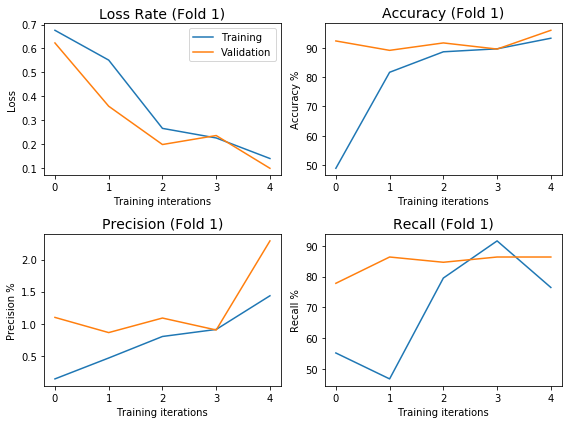

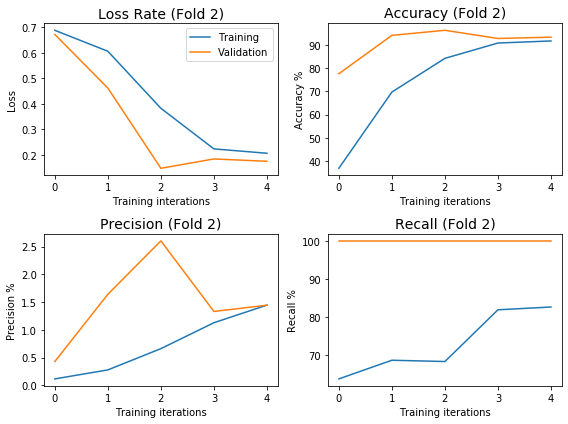

In [156]:
for i in range(shuffle.get_n_splits()):
    
    fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2, figsize=(8,6))

    loss_rate_plot(fithists[i], ax1, legend=True, label="Fold %d"%(i+1))
    accuracy_rate_plot(fithists[i], ax2, label="Fold %d"%(i+1))
    precision_rate_plot(fithists[i], ax3, label="Fold %d"%(i+1))
    recall_rate_plot(fithists[i], ax4, label="Fold %d"%(i+1))

    fig.tight_layout()
    
plt.show()

### Confusion Matrix

In [157]:
def plot_confusion_matrix(ax, y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    A function to plot the confusion matrix.
    """
    if title is None:
        title = "Confusion Matrix"

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), 
             rotation=45,
             ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ','
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", 
                    va="center",
                    color="white" if cm[i, j] > thresh else "black")

Processing confusion matrix for fold 1.
Processing confusion matrix for fold 2.


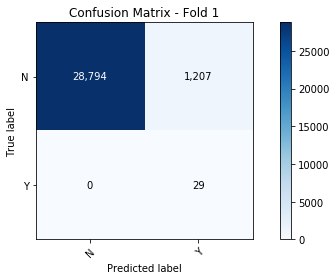

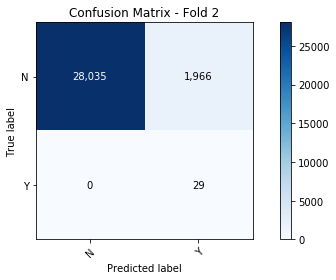

In [158]:
for ifold, (train_ix, test_ix) in enumerate(shuffle.split(X,y)):
    
    fig, ax = plt.subplots(1,1,figsize=(8,4))

    print("Processing confusion matrix for fold %d."%(ifold+1))
    
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    
    model = models[ifold]
    
    y_test_pred = model.predict(X_test)
        
    y_test_pred = np.round(y_test_pred)

    plot_confusion_matrix(ax, y_test, y_test_pred, ['N','Y'], title="Confusion Matrix - Fold %d"%(ifold+1))
    
    fig.tight_layout()

plt.show()

## Visualizing ROC Curve

Our last step is to visualize the ROC curve.

Because of the k-fold cross-validation, we have multiple versions of the same model, trained on different testing-training splits of the data set. We can use these to construct an ROC curve with a confidence interval.

Working on fold 1...
Working on fold 2...
Area under curve:
Mean: 0.9932
Std: 0.0018


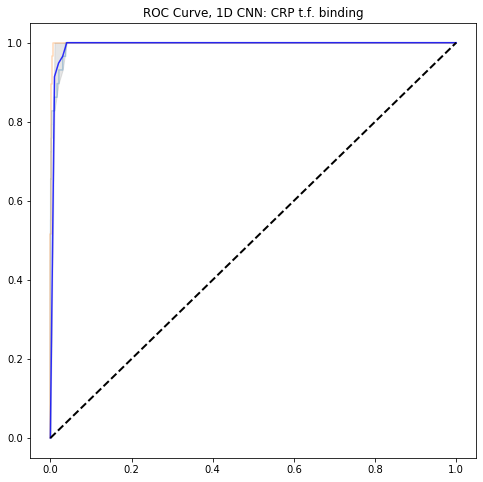

In [173]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

# Use a single plot

fig, ax = plt.subplots(1,1,figsize=(8,8))

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)

# Start by plotting each individual ROC curve

for ifold, (train_ix, test_ix) in enumerate(shuffle.split(X,y)):

    print("Working on fold %d..."%(ifold+1))
    
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    sample_weights_train, sample_weights_test = sample_weights[train_ix], sample_weights[test_ix]
    
    model = models[ifold]
    y_test_pred = model.predict(X_test).ravel()
    
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred, sample_weight=sample_weights_test)
    
    tprs.append(interp(mean_fpr,fpr,tpr))
    tprs[-1][0] = 0.0
    
    roc_auc = auc(fpr,tpr)
    aucs.append(roc_auc)
    
    ax.plot(fpr,tpr, alpha=0.3)

# Now compute statistics from the multiple models
# and use that to construct a confidence interval

mean_tpr = np.mean(tprs,axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b', alpha=0.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)

ax.plot([0,1],[0,1],'--k',lw=2)

ax.set_title('ROC Curve, 1D CNN: CRP t.f. binding')

print("Area under curve:")
print("Mean: %0.4f"%(mean_auc))
print("Std: %0.4f"%(std_auc))

plt.show()